In [516]:
using Glob
using NPZ
using Plots
using StatsBase
using EvalMetrics
using locaTE
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-BFStrange/dyn-BFStrange-1000-*");
dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-SW/dyn-SW-1000-*");
# dirs = Glob.glob("../../data/simulated/Synthetic_2000_noise/dyn-SW/dyn-SW-2000-*");

In [517]:
dropout = map(x -> parse(Float64, split(split(x, "-")[end], "_")[5]), dirs);
noise = map(x -> parse(Float64, split(split(x, "-")[end], "_")[3]), dirs);
sim = map(x -> parse(Int, split(split(x, "-")[end], "_")[1]), dirs);

In [518]:
# ground truth
J = permutedims(npzread(joinpath(dirs[1], "J.npy")), [1, 3, 2]);
J_static = (mean(abs.(J); dims = 1)[1, :, :] .> 0.05)*1.0;

# load 
path = [joinpath(Glob.glob(joinpath(d, "locate_output_*"))[1], "G_static_cdf_velo_dot.npy") for d in dirs]
G_static_all = [try npzread(x) catch nothing end for x in path];
X_all = [npzread(joinpath(d, "X.npy")) for d in dirs];

sim_vals = sort(unique(sim));
noise_vals = sort(unique(noise));
dropout_vals = sort(unique(dropout));

y = zeros(length(sim_vals), length(noise_vals), length(dropout_vals))
for (i, (_sim, _noise, _dropout)) in enumerate(zip(sim, noise, dropout))
    y[sim_vals .== _sim, noise_vals .== _noise, dropout_vals .== _dropout] .= try au_prcurve(vec(J_static), vec(G_static_all[i])) catch e NaN end
end

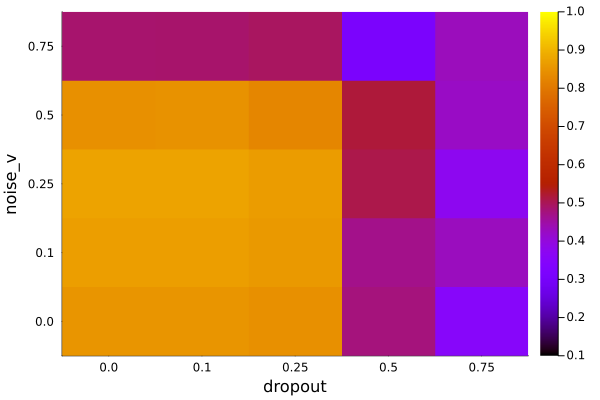

In [519]:
heatmap(y[1, :, :]; xticks = (1:length(t_vals), t_vals), yticks = (1:length(s_vals), s_vals), xlabel = "dropout", ylabel = "noise_v", clim = (0.1, 1), cmap = :gnuplot)

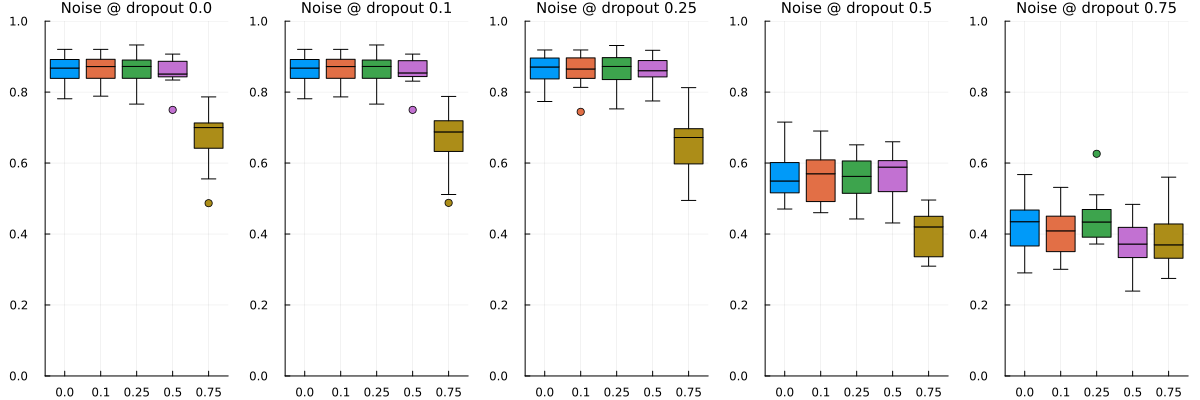

In [520]:
using StatsPlots
plot([boxplot(y[:, :, k], xticks = (1:length(noise_vals), noise_vals), title = "Noise @ dropout $(dropout_vals[k])", titlefontsize = 10, ylim = (0, 1), legend = nothing) for k = 1:length(dropout_vals)]...; layout = (1, 5), size = (1200, 400))

In [521]:
include("comparisons/process_outputs_util.jl")

process_genie3 (generic function with 1 method)

In [527]:
using CSV, DataFrames, LinearAlgebra
Ng = size(J, 2)

# dirs = Glob.glob("../../data/simulated/Synthetic_2000_noise/dyn-SW/dyn-SW-2000-*_noise_0_*");
dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-SW/dyn-SW-1000-*_noise_0_*");
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-BFStrange/dyn-BFStrange-1000-*_noise_0_*");
# path = [joinpath(d, "genie3/A.csv") for d in dirs]
# path = [joinpath(d, "sincerities/A.txt") for d in dirs]
path = [joinpath(d, "scribe/G_scribe.npy") for d in dirs]
# G_pidc_all = [try npzread(x) catch nothing end for x in path];
G_pidc_all = [try process_scribe(x, J_static)[1] catch nothing end for x in path];

dropout = map(x -> parse(Float64, split(split(x, "-")[end], "_")[5]), dirs);
sim = map(x -> parse(Int, split(split(x, "-")[end], "_")[1]), dirs);

y = zeros(length(sim_vals), length(dropout_vals))
for (i, (_sim, _dropout)) in enumerate(zip(sim, dropout))
    y[sim_vals .== _sim, dropout_vals .== _dropout] .= try au_prcurve(vec(J_static), vec(G_pidc_all[i])) catch e NaN end
end

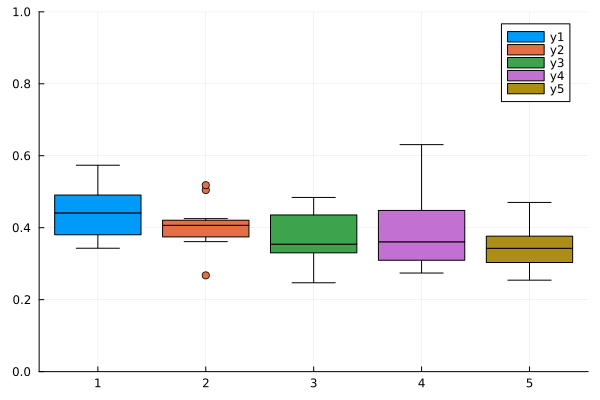

In [528]:
boxplot(y; ylim = (0, 1))

In [524]:
# using EvalMetrics
# plt=plot()
# for (i, (s, t)) in enumerate(zip(noise, dropout))
#     try
#         prplot!(vec(J_static), vec(G_static_all[i]); label = "noise = $s, dropout = $t")
#     catch 
#     end
# end
# plt

In [525]:
# length(unique(noise))

In [526]:
# plot([try heatmap(g; title = "s = $s, t= $t") catch e plot() end for (g, s, t) in zip(G_static_all, noise, dropout)]...; layout = (length(unique(noise)), length(unique(dropout))), colorbar = false, size = (1000, 1000))